In [1]:
import toolbox_path
import os
import tqdm

%matplotlib inline

from planning_toolbox.parser import parse_file
from planning_toolbox.solvers import *
from planning_toolbox.determinization import *

from utils import *

In [2]:
folder = "../benchmarks/imagine_simple/"
domain = parse_file(folder+"domain.pddl", "domain")
problems = sorted(folder+f for f in os.listdir(folder) if PROBLEM_FILE_RE.match(f))
print(domain)

(define (domain imagine)

(:requirements :adl :rewards :probabilistic-effects)

(:types screw - removable-component
screwdriver - tool
static-component removable-component - component
tool component mode affordance-confidence side affordance - object
suction-point lever-point pliers-point - affordance)

(:constants top bottom front back left right - side low medium high - affordance-confidence scara power no-mode - mode flat-sd star-sd - screwdriver hammer suction-tool pliers cutter no-tool - tool)

(:predicates
  (has-affordance ?c - removable-component ?a - affordance)
  (has-confidence ?a - affordance ?c - affordance-confidence)
  (broken-component ?c - removable-component)
  (broken-tool ?t - tool)
  (connected ?c1 ?c2 - component)
  (clear ?c - removable-component)
  (current-mode ?m - mode)
  (current-side ?s - side)
  (current-tool ?t - tool)
  (held)
  (fixed-by ?c - removable-component ?s - screw)
  (loose ?c - removable-component)
  (partially-occludes ?c1 ?c2 - component)
  

In [3]:
determinizer = AlphaCostLikelihoodDeterminizer(alpha=0, round_=4)
determinizer.set_domain(domain)
print(determinizer.determinized_domain)

(define (domain imagine)

(:requirements :adl)

(:types screw - removable-component
screwdriver - tool
static-component removable-component - component
tool component mode affordance-confidence side affordance - object
suction-point lever-point pliers-point - affordance)

(:constants top bottom front back left right - side low medium high - affordance-confidence scara power no-mode - mode flat-sd star-sd - screwdriver hammer suction-tool pliers cutter no-tool - tool)

(:predicates
  (has-affordance ?c - removable-component ?a - affordance)
  (has-confidence ?a - affordance ?c - affordance-confidence)
  (broken-component ?c - removable-component)
  (broken-tool ?t - tool)
  (connected ?c1 ?c2 - component)
  (clear ?c - removable-component)
  (current-mode ?m - mode)
  (current-side ?s - side)
  (current-tool ?t - tool)
  (held)
  (fixed-by ?c - removable-component ?s - screw)
  (loose ?c - removable-component)
  (partially-occludes ?c1 ?c2 - component)
  (removed-non-verified ?c - remov

In [8]:
solver = FDPlanner(search="astar(hmax())")
# solver = FFPlanner(s=3, w=1)
problem = parse_file(problems[0], "problem", domain)

alphas = []
plan_cost = []
plan_prob = []
plans = []

for alpha in tqdm.tqdm(list(linspace(0, 0.5, 100))):
    determinizer.alpha = alpha
    determinizer.reset()
    deterministic_problem = determinizer(problem)
    result = solver(deterministic_problem, timeout=30)
    if result["plan-found"]:
        cost = result["total-cost"]
        prob, plan = determinizer.process_plan_trace(result["plan"])
        alphas.append(alpha)
        plan_cost.append(cost)
        plan_prob.append(prob)
        plans.append(plan)
    else:
        print(result["stdout"])
        print(result["stderr"])
        break


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


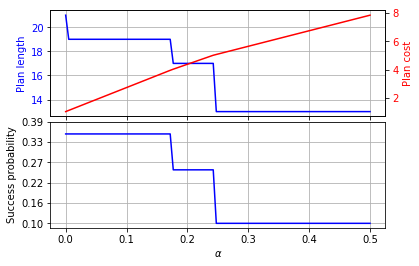

In [16]:
import importlib
import utils
importlib.reload(utils)

utils.plot_results_actl(alphas, plan_prob, [len(p) for p in plans], [c/10000 for c in plan_cost],
                  save="imagine01alpha.pdf")

In [10]:
print_plan("1st plan", plans[0])
print_plan("2nd plan", plans[int((0.1 - 0)*99/0.5)])
print_plan("3rd plan", plans[int((0.2 - 0)*99/0.5)])
print_plan("4th plan", plans[int((0.4 - 0)*99/0.5)])

1st plan (21 actions):
  (grab-device)
  (flip top bottom)
  (place-device)
  (pick-tool star-sd power)
  (unscrew-power-non-stuck pcb-s4 star-sd bottom)
  (put-away-tool star-sd power)
  (pick-tool flat-sd power)
  (unscrew-power-non-stuck pcb-s0 flat-sd bottom)
  (unscrew-power-non-stuck pcb-s1 flat-sd bottom)
  (unscrew-power-non-stuck pcb-s2 flat-sd bottom)
  (unscrew-power-non-stuck pcb-s3 flat-sd bottom)
  (put-away-tool flat-sd power)
  (grab-device)
  (pick-tool cutter scara)
  (cut-connector motor-axis pcb bottom)
  (place-device)
  (put-away-tool cutter scara)
  (pick-tool pliers power)
  (assert-clear pcb)
  (extract-with-pliers-high-confidence pcb pcb-a4 bottom)
  (check-removed pcb bottom)
2nd plan (19 actions):
  (grab-device)
  (flip top bottom)
  (pick-tool cutter scara)
  (cut-connector motor-axis pcb bottom)
  (place-device)
  (put-away-tool cutter scara)
  (pick-tool star-sd power)
  (unscrew-power-non-stuck pcb-s4 star-sd bottom)
  (put-away-tool star-sd power)
  (p